In [8]:
import simpy
import random

class HousingPipeline:
    def __init__(self, env):
        self.env = env
        # Containers for each stage and initial amounts
        self.in_planning = simpy.Container(env, init=1000)
        self.approved_not_started = simpy.Container(env, init=1000)
        self.started = simpy.Container(env, init=1000)
        self.completed = simpy.Container(env, init=1000)
        
        # Flow rates (proportion of containers processed per quarter)
        self.application_rate = 1000  # Keep this fixed as input
        self.approval_rate = 0.3      # Process 30% of planning applications per quarter
        self.start_rate = 0.25        # Start 25% of approved applications per quarter
        self.completion_rate = 0.2    # Complete 20% of started homes per quarter
        
        # Success rates (percentage that successfully moves to next stage)
        self.planning_success_rate = 0.8
        self.approved_to_start_rate = 0.9
        self.start_to_completion_rate = 0.95
        
        # Start processes
        self.env.process(self.application_flow())
        self.env.process(self.approval_flow())
        self.env.process(self.start_flow())
        self.env.process(self.completion_flow())
    
    def application_flow(self):
        while True:
            yield self.in_planning.put(self.application_rate)
            yield self.env.timeout(1)
    
    def approval_flow(self):
        while True:
            amount = self.in_planning.level * self.approval_rate
            successful_amount = amount * self.planning_success_rate
            yield self.in_planning.get(amount)
            yield self.approved_not_started.put(successful_amount)
            yield self.env.timeout(1)
    
    def start_flow(self):
        while True:
            amount = self.approved_not_started.level * self.start_rate
            successful_amount = amount * self.approved_to_start_rate
            yield self.approved_not_started.get(amount)
            yield self.started.put(successful_amount)
            yield self.env.timeout(1)
    
    def completion_flow(self):
        while True:
            amount = self.started.level * self.completion_rate
            successful_amount = amount * self.start_to_completion_rate
            yield self.started.get(amount)
            yield self.completed.put(successful_amount)
            yield self.env.timeout(1)

# Initialize environment
env = simpy.Environment()
pipeline = HousingPipeline(env)

# Run simulation
env.run(until=12)  # Run for 12 quarters

([<matplotlib.axis.XTick at 0x1282b8860>,
 [Text(0, 0, '2025 Q1'),
  Text(1, 0, '2025 Q2'),
  Text(2, 0, '2025 Q3'),
  Text(3, 0, '2025 Q4'),
  Text(4, 0, '2026 Q1'),
  Text(5, 0, '2025 Q2'),
  Text(6, 0, '2025 Q3'),
  Text(7, 0, '2025 Q4'),
  Text(8, 0, '2027 Q1'),
  Text(9, 0, '2025 Q2'),
  Text(10, 0, '2025 Q3'),
  Text(11, 0, '2025 Q4')])

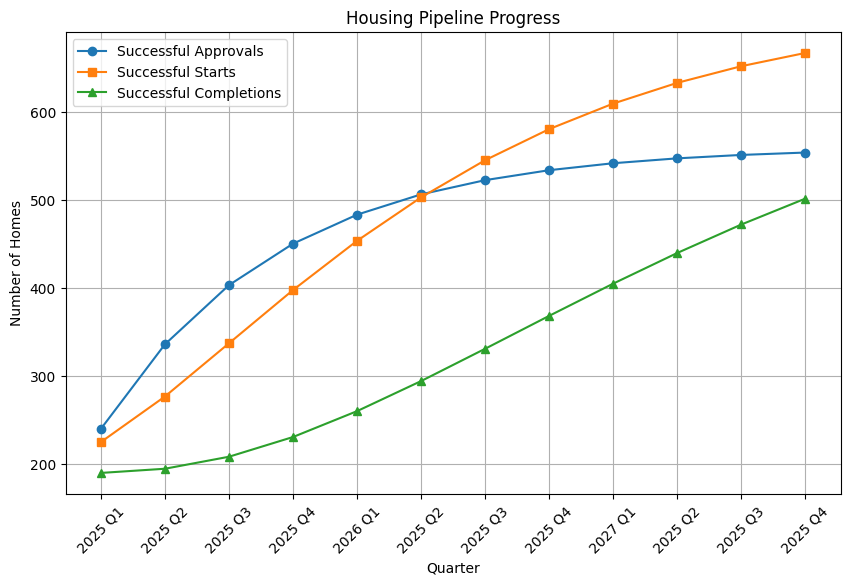

In [12]:
import matplotlib.pyplot as plt

# Get values at each timestep
approvals = []
starts = []
completions = []

# Reset environment
env = simpy.Environment()
pipeline = HousingPipeline(env)

# Run simulation and collect data
for quarter in range(12):
    # Calculate successful amounts for this quarter
    approval_amount = pipeline.in_planning.level * pipeline.approval_rate * pipeline.planning_success_rate
    start_amount = pipeline.approved_not_started.level * pipeline.start_rate * pipeline.approved_to_start_rate
    completion_amount = pipeline.started.level * pipeline.completion_rate * pipeline.start_to_completion_rate
    
    # Store the amounts
    approvals.append(approval_amount)
    starts.append(start_amount)
    completions.append(completion_amount)
    
    # Run simulation for one quarter
    env.run(until=quarter + 1)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(range(12), approvals, label='Successful Approvals', marker='o')
plt.plot(range(12), starts, label='Successful Starts', marker='s')
plt.plot(range(12), completions, label='Successful Completions', marker='^')
plt.xlabel('Quarter')
plt.ylabel('Number of Homes')
plt.title('Housing Pipeline Progress')
plt.legend()
plt.grid(True)

# Create quarter labels
quarters = [f'2025 Q{i%4 + 1}' if i%4 != 0 else f'{2025 + i//4} Q1' for i in range(12)]
plt.xticks(range(12), quarters, rotation=45)